### Imports

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gymnasium as gym
import gym_anytrading
from gym_anytrading.envs import Actions

from stable_baselines3 import A2C, PPO

import quantstats as qs

In [33]:
from stable_baselines3 import A2C, PPO

### Create Env

In [55]:
import yfinance as yf

df = yf.Ticker("ADBE")
df = df.history(period="max")
df = df.loc['2022-01-01':, :]
# Calculate Moving Averages
df['SMA'] = df['Close'].rolling(window=5).mean()  # Short-term moving average
df['LMA'] = df['Close'].rolling(window=20).mean()  # Long-term moving average

# Calculate RSI
delta = df['Close'].diff(1)
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

# Calculate MACD
df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = df['EMA12'] - df['EMA26']
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
        
# Handling NaN values that may appear due to the rolling and ewm functions
df.fillna(0, inplace=True)

window_size = 10
start_index = window_size
end_index = len(df)

env = gym.make(
    'stocks-v0',
    df=df,
    window_size=window_size,
    frame_bound=(start_index, end_index)
)

print("observation_space:", env.observation_space)

observation_space: Box(-10000000000.0, 10000000000.0, (10, 2), float32)


In [49]:
# # Calculate Moving Averages
# df['SMA'] = df['Close'].rolling(window=5).mean()  # Short-term moving average
# df['LMA'] = df['Close'].rolling(window=20).mean()  # Long-term moving average

# # Calculate RSI
# delta = df['Close'].diff(1)
# gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
# loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
# rs = gain / loss
# df['RSI'] = 100 - (100 / (1 + rs))

# # Calculate MACD
# df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
# df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
# df['MACD'] = df['EMA12'] - df['EMA26']
# df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
        
# # Handling NaN values that may appear due to the rolling and ewm functions
# df.fillna(0, inplace=True)
# df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,SMA,LMA,RSI,EMA12,EMA26,MACD,Signal_Line
Date,,,,,,,,,,,,,,
2022-01-03 00:00:00-05:00,566.650024,575.000000,553.270020,564.369995,2862700,0.0,0.0,0.000000,0.0,0.0,564.369995,564.369995,0.000000,0.000000
2022-01-04 00:00:00-05:00,563.900024,564.299988,541.309998,554.000000,4344800,0.0,0.0,0.000000,0.0,0.0,562.774611,563.601847,-0.827236,-0.165447
2022-01-05 00:00:00-05:00,535.000000,538.750000,514.000000,514.429993,7394800,0.0,0.0,0.000000,0.0,0.0,555.336978,559.959488,-4.622510,-1.056860
2022-01-06 00:00:00-05:00,510.000000,526.309998,508.200012,514.119995,3913600,0.0,0.0,0.000000,0.0,0.0,548.995903,556.563970,-7.568066,-2.359101
2022-01-07 00:00:00-05:00,513.659973,520.419983,504.000000,510.700012,3605400,0.0,0.0,531.523999,0.0,0.0,543.104228,553.166640,-10.062412,-3.899763


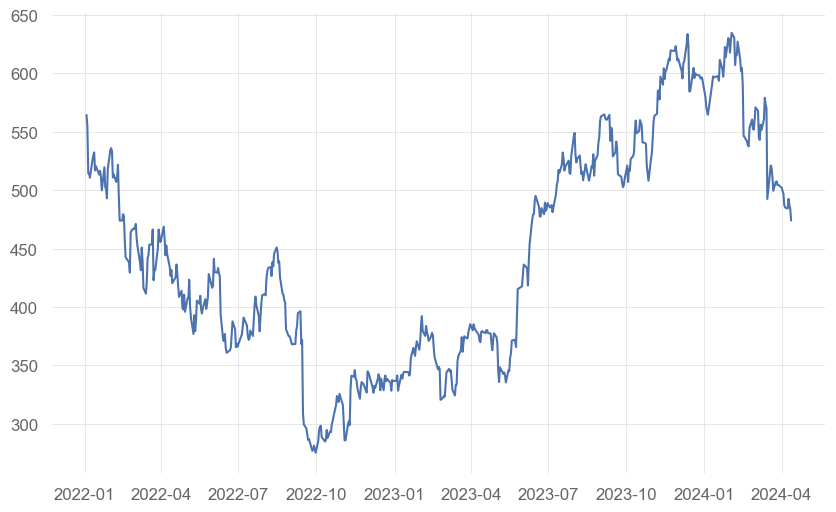

In [44]:
plt.plot(df.Close)

In [28]:
# df = gym_anytrading.datasets.STOCKS_GOOGL.copy()

# window_size = 10
# start_index = window_size
# end_index = len(df)

# env = gym.make(
#     'stocks-v0',
#     df=df,
#     window_size=window_size,
#     frame_bound=(start_index, end_index)
# )

# print("observation_space:", env.observation_space)

### Train Env

In [29]:
env.reset(seed=2023)
model = A2C('MlpPolicy', env, verbose=0)
model.learn(total_timesteps=1000)

In [56]:
env.reset(seed=2023)
model = PPO('MlpPolicy', env, verbose=0)
model.learn(total_timesteps=100)

### Test Env

In [57]:
action_stats = {Actions.Sell: 0, Actions.Buy: 0}

observation, info = env.reset(seed=2023)

while True:
    # action = env.action_space.sample()
    action, _states = model.predict(observation)

    action_stats[Actions(action)] += 1
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # env.render()
    if done:
        break

env.close()

print("action_stats:", action_stats)
print("info:", info)

action_stats: {<Actions.Sell: 0>: 298, <Actions.Buy: 1>: 263}
info: {'total_reward': 58.509613037109375, 'total_profit': 0.12260532170415052, 'position': <Positions.Short: 0>}


### Plot Results

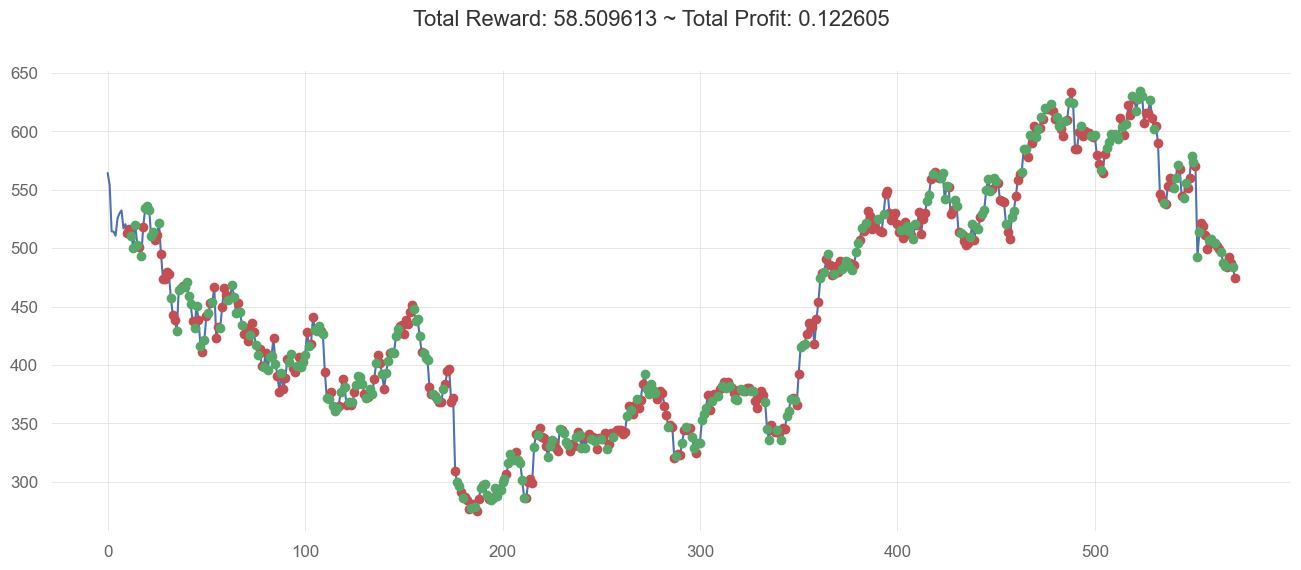

In [58]:
plt.figure(figsize=(16, 6))
env.unwrapped.render_all()
plt.show()

### Analysis Using `quantstats`

c:\Users\supha\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old

                           Strategy
-------------------------  ----------
Start Period               2010-07-16
End Period                 2024-04-12
Risk-Free Rate             0.0%
Time in Market             26.0%

Cumulative Return          -100.0%
CAGR﹪                     -40.42%

Sharpe                     -1.6
Prob. Sharpe Ratio         0.0%
Smart Sharpe               -1.58
Sortino                    -2.08
Smart Sortino              -2.06
Sortino/√2                 -1.47
Smart Sortino/√2           -1.46
Omega                      0.57

Max Drawdown               -100.0%
Longest DD Days            4880
Volatility (ann.)          41.54%
Calmar                     -0.4
Skew                       0.21
Kurtosis                   24.47

Expected Daily %           -0.3%
Expected Monthly %         -6.02%
Expected Yearly %          -49.72%
Kelly Criterion            -27.45%
Risk of Ruin               0.0%
Daily Value-at-Risk        -4.57%
Expected Shortfall (cVaR)  -4.57%

Max Consecutive

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2010-12-03,2024-04-01,2024-04-12,4879,-99.997174,-99.996845
2,2010-07-26,2010-09-20,2010-11-26,124,-17.263972,-16.311852


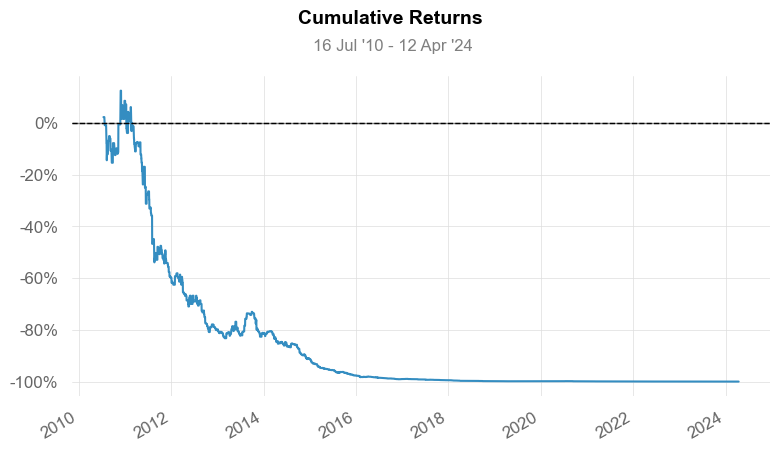

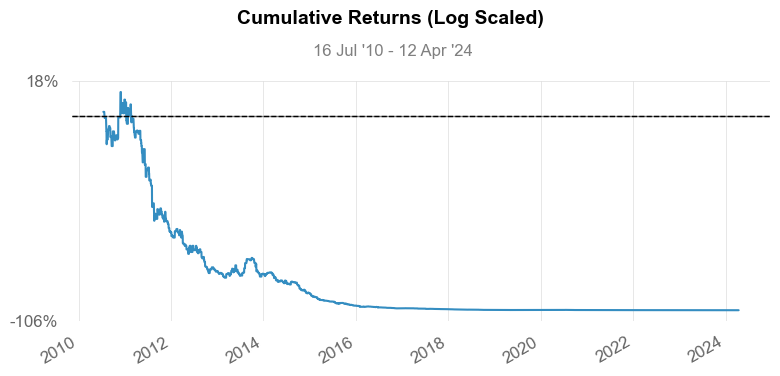

c:\Users\supha\AppData\Local\Programs\Python\Python39\lib\site-packages\quantstats\_plotting\wrappers.py:565: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  returns = returns.resample("A").apply(_stats.comp)
c:\Users\supha\AppData\Local\Programs\Python\Python39\lib\site-packages\quantstats\_plotting\wrappers.py:568: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  returns = returns.resample("A").last()


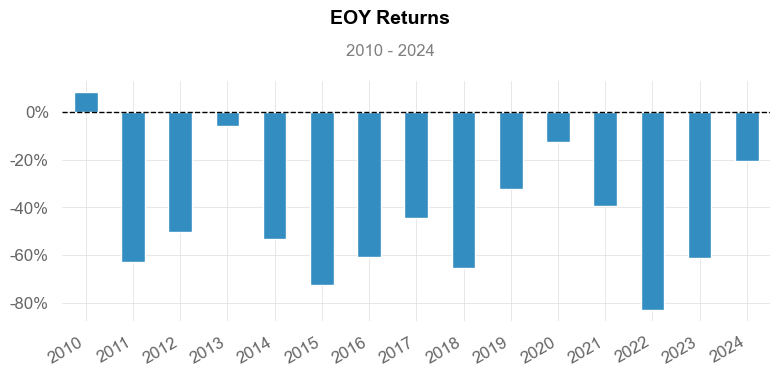

c:\Users\supha\AppData\Local\Programs\Python\Python39\lib\site-packages\quantstats\_plotting\core.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  returns.fillna(0).resample(resample).apply(apply_fnc).resample(resample).last()
c:\Users\supha\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

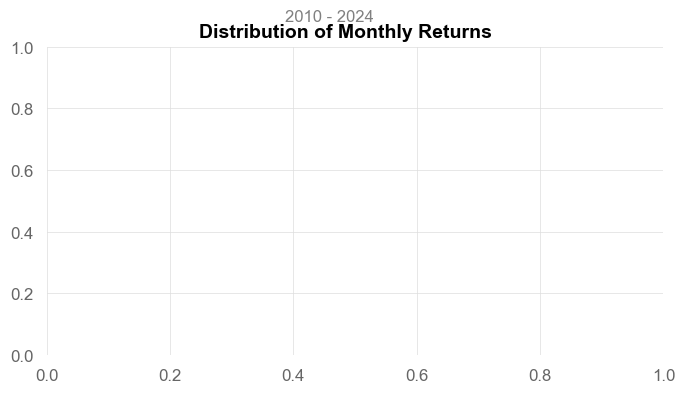

In [9]:
qs.extend_pandas()

net_worth = pd.Series(env.unwrapped.history['total_profit'], index=df.index[start_index+1:end_index])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)
qs.reports.html(returns, output='SB3_a2c_quantstats.html')